In [1]:
install.packages("properties")
library(properties)

envProps <- read.properties("../env.properties")

Sys.setenv(
    "AWS_ACCESS_KEY_ID" = envProps$access_key, 
    "AWS_SECRET_ACCESS_KEY" = envProps$secret_key,
    "AWS_DEFAULT_REGION" = 'us-east-1')


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message in readLines(file):
“incomplete final line found on '../env.properties'”


Clear the workspace

In [2]:
rm(list = ls())

Installing and loading the packages needed for this notebook

In [3]:
if (!'Metrics' %in% installed.packages()) {install.packages("Metrics")}
if (!'tidyverse' %in% installed.packages()) {install.packages("tidyverse")}
if (!'caret' %in% installed.packages()) {install.packages("caret")}

suppressWarnings(library(reticulate))
suppressWarnings(library(readr))
suppressWarnings(library(ggplot2))
suppressWarnings(library(dplyr))
suppressWarnings(library(stringr))
suppressWarnings(library(Metrics))
suppressWarnings(library(tidyverse))
suppressWarnings(library(caret))
suppressWarnings(library(pROC))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following objects are masked from ‘package:Metrics’:

    precision, recall


Type 'citation("pROC")' for a citation.


Attaching package: ‘

Next, loading the Reticulate library and import the SageMaker Python module. Reticulate provides interface to 'Python' modules, classes, and functions.

Amazon SageMaker Python SDK is an open source library for training and deploying machine-learned models on Amazon SageMaker. With the SDK, you can train and deploy models using popular deep learning frameworks, algorithms provided by Amazon, or your own algorithms built into SageMaker-compatible Docker images. <https://sagemaker.readthedocs.io/en/stable/>

In [4]:
library(reticulate)
path_to_python <- system("which python", intern = TRUE)
use_python(path_to_python)

sagemaker <- import('sagemaker')
session <- sagemaker$Session()
bucket <- session$default_bucket()
role_arn <- sagemaker$get_execution_role()
print(role_arn)

[1] "arn:aws:iam::482851446821:role/service-role/AmazonSageMaker-ExecutionRole-20230917T140007"


Reading the data file churn.txt. The data is for customer churn in a telecommunication organization (synthetic data). The goal is to predict whether a customer is going to churn or not.

In [5]:
sagemaker$s3$S3Downloader$download("s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt", "dataset")
churn <- read_csv(file = "dataset/churn.txt", col_names = TRUE, show_col_types = FALSE)
head(churn)

[1] "dataset/churn.txt"

State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,⋯,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,⋯,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,⋯,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,⋯,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,⋯,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,⋯,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.
VA,83,866,454-9110,no,no,0,3.634776,7,4.804892,⋯,5,5.278437,2.937880,300,4.817958,4.948816,4,5.135323,5,False.


Carrying out various data preprocessing steps

In [6]:
#Transforming the categorical variables to dummy variables since Xgboost only takes numerical inputs for features
#Now dropping certain columns that are redundant using dplyr's select method
churn = select(churn, -c("Phone", "Day Charge", "Eve Charge", "Night Charge", "Intl Charge"))

churn <- rename(churn, "intlplan" = "Int'l Plan")
churn <- rename(churn, "churn" = "Churn?")

Plotting international plan histogram as a function of target variable "churn" using ggplot2

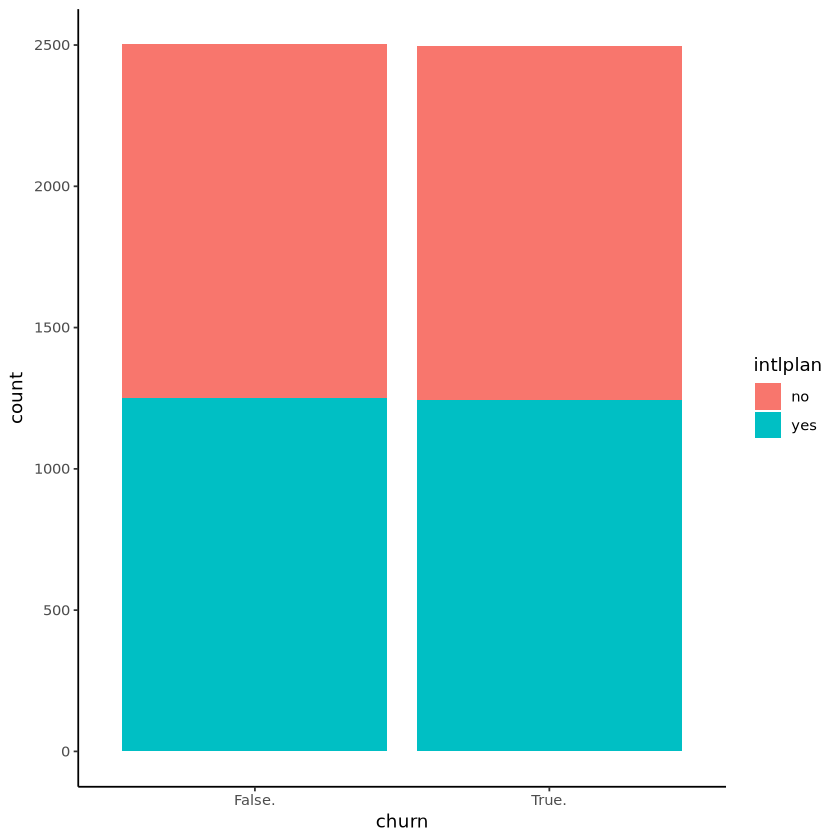

In [7]:
ggplot(churn, aes(x = churn, fill = intlplan)) +  geom_bar() + theme_classic()

Plotting histograms for customer service calls as a function of target variable (churn), using R's hist function

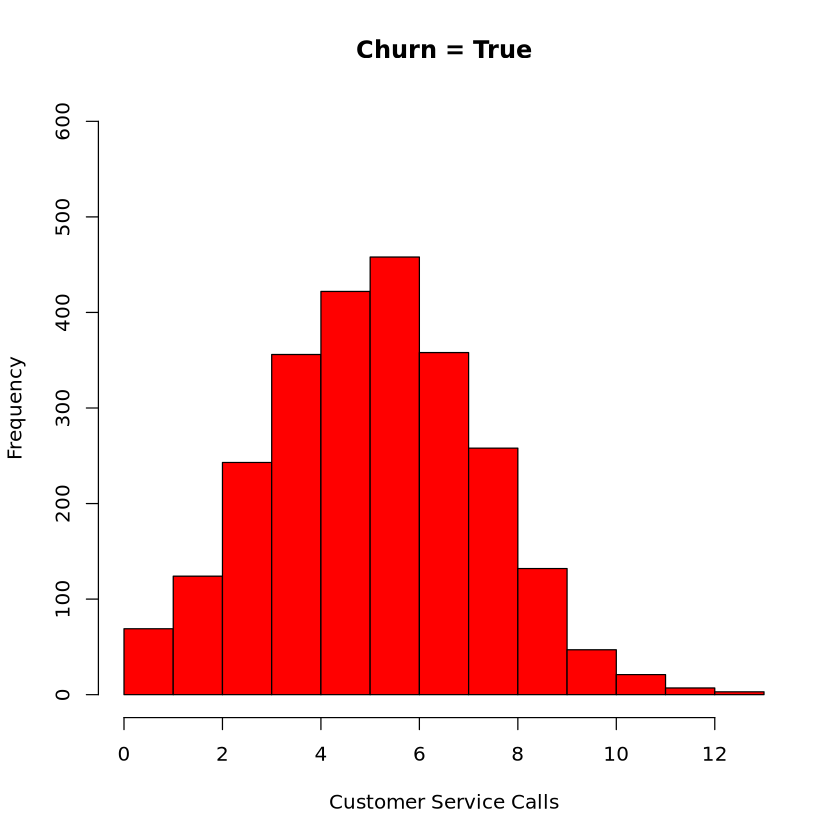

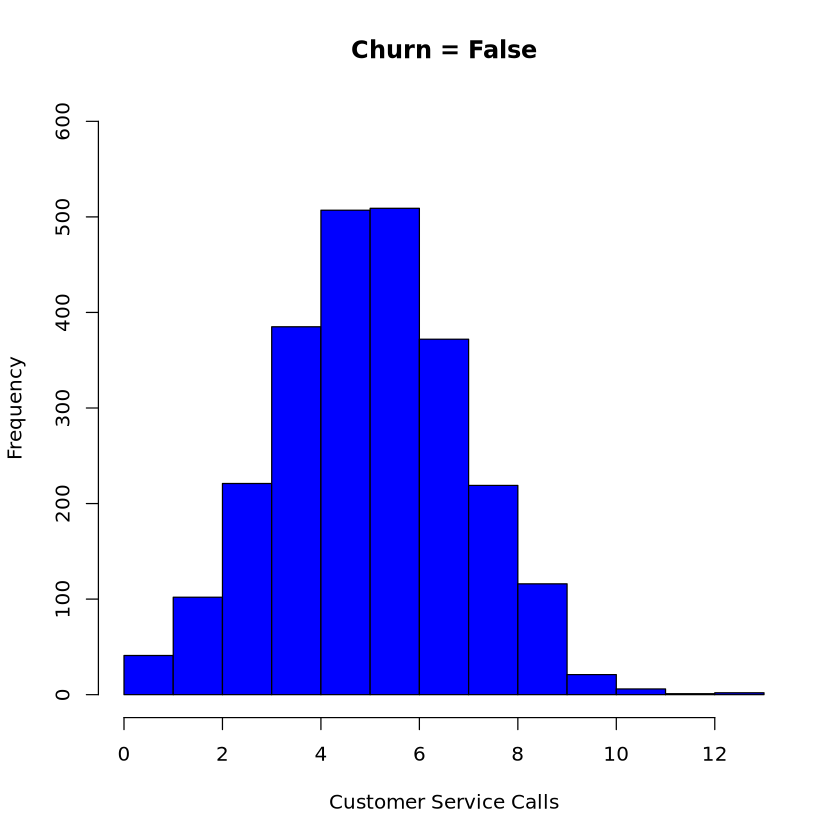

In [8]:
hist(churn$"CustServ Calls"[which(churn$churn == "True.")], col = 'red', breaks = 15, ylim = c(0,600), main = "Churn = True", xlab = "Customer Service Calls")
hist(churn$"CustServ Calls"[which(churn$churn == "False.")], col = 'blue', breaks = 15, ylim = c(0,600),main = "Churn = False", xlab = "Customer Service Calls")

Additional pre-processing steps

In [9]:
#Changing target variable churn into dummy variable and keeping just True column while dropping False
churn <- churn %>% mutate(dummy=1) %>% spread(key="churn",value=dummy, fill=0)
churn <- subset(churn, select = -c(False.))
churn <- rename(churn, "churn" = True.)

#Making the target variable "churn" as the first column as XGBoost expects the data to be in this format
churn <- churn %>% select("churn", everything())

#Transforming intlplan (international plan) to dummy, dropping resulting "no" variable and renaming "yes" using dplyr's rename method
churn <- churn %>% mutate(dummy=1) %>% spread(key="intlplan",value=dummy, fill=0)
churn <- subset(churn, select = -c(no))
churn <- rename(churn, "intlplan" = yes)

#Transforming VMaill plan to dummy, dropping resulting "no" variable and renaming "yes" using dplyr's rename method
churn <- churn %>% mutate(dummy=1) %>% spread(key="VMail Plan",value=dummy, fill=0)
churn <- subset(churn, select = -c(no))
churn <- rename(churn, "VMail plan" = yes)

#Transforming variable "State" into dummy variables
churn <- churn %>% mutate(dummy=1) %>% spread(key="State",value=dummy, fill=0)
head(churn)

churn,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,⋯,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,163,806,300,8.162204,3,3.933035,4,4.065759,100,⋯,0,0,0,0,0,0,0,0,0,0
0,15,836,0,10.018993,4,2.325005,0,7.141040,200,⋯,0,0,0,0,0,0,0,0,0,0
0,131,777,300,4.708490,3,4.537466,3,5.363235,100,⋯,0,0,0,0,0,0,0,0,0,0
0,75,878,700,1.268734,3,2.528748,5,3.773586,450,⋯,0,0,0,0,0,0,0,0,0,1
1,146,878,0,2.696177,3,6.015337,3,3.751673,250,⋯,0,0,0,0,0,0,0,0,0,1
0,83,866,0,3.634776,7,6.051944,5,2.937880,300,⋯,0,0,0,0,1,0,0,0,0,0


Dividing the dataset into train, validation and test datasets and writing the csv files in current directory

In [10]:
churn_train <- churn %>% sample_frac(size = 0.7)
churn <- anti_join(churn, churn_train)
churn_test <- churn %>% sample_frac(size = 0.5)
churn_valid <- anti_join(churn, churn_test)

write_csv(churn_train, 'dataset/churn_train.csv', col_names = FALSE)
write_csv(churn_valid, 'dataset/churn_valid.csv', col_names = FALSE)
# Remove target from test
write_csv(churn_test[-1], 'dataset/churn_test.csv', col_names = FALSE)

Joining with `by = join_by(churn, `Account Length`, `Area Code`, `VMail
Message`, `Day Mins`, `Day Calls`, `Eve Mins`, `Eve Calls`, `Night Mins`,
`Night Calls`, `Intl Mins`, `Intl Calls`, `CustServ Calls`, intlplan, `VMail
plan`, AK, AL, AR, AZ, CA, CO, CT, DC, DE, FL, GA, HI, IA, ID, IL, IN, KS, KY,
LA, MA, MD, ME, MI, MN, MO, MS, MT, NC, ND, NE, NH, NJ, NM, NV, NY, OH, OK, OR,
PA, RI, SC, SD, TN, TX, UT, VA, VT, WA, WI, WV, WY)`
Joining with `by = join_by(churn, `Account Length`, `Area Code`, `VMail
Message`, `Day Mins`, `Day Calls`, `Eve Mins`, `Eve Calls`, `Night Mins`,
`Night Calls`, `Intl Mins`, `Intl Calls`, `CustServ Calls`, intlplan, `VMail
plan`, AK, AL, AR, AZ, CA, CO, CT, DC, DE, FL, GA, HI, IA, ID, IL, IN, KS, KY,
LA, MA, MD, ME, MI, MN, MO, MS, MT, NC, ND, NE, NH, NJ, NM, NV, NY, OH, OK, OR,
PA, RI, SC, SD, TN, TX, UT, VA, VT, WA, WI, WV, WY)`


Writing the data to S3 bucket for the model training job

In [11]:
s3_train <- session$upload_data(path = 'dataset/churn_train.csv', bucket = bucket, key_prefix = 'r_example/data')
s3_valid <- session$upload_data(path = 'dataset/churn_valid.csv', bucket = bucket, key_prefix = 'r_example/data')
s3_test <- session$upload_data(path = 'dataset/churn_test.csv',   bucket = bucket, key_prefix = 'r_example/data')

Specifying the training and validation data channels for model training

In [12]:
s3_train_input <- sagemaker$inputs$TrainingInput(s3_data = s3_train, content_type = 'csv')
s3_valid_input <- sagemaker$inputs$TrainingInput(s3_data = s3_valid, content_type = 'csv')
input_data <- list('train' = s3_train_input, 'validation' = s3_valid_input)

Using the SageMaker's builtin XGBoost model container for model training and the output path for model artifacts

In [13]:
container <- sagemaker$image_uris$retrieve(framework='xgboost', region= session$boto_region_name, version='latest')
cat('XGBoost Container Image URL: ', container)
s3_output <- paste0('s3://', bucket, '/r_example/output')

XGBoost Container Image URL:  811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest

Specifying the number of instances and instance type to train the model on along with model image uri, role and input mode. Also setting up the training job as binary classification with objective metric as error.

In [14]:
estimator <- sagemaker$estimator$Estimator(image_uri = container,
                                           role = role_arn,
                                           instance_count = 1L,
                                           instance_type = 'ml.m5.xlarge',
                                           input_mode = 'File',
                                           output_path = s3_output)
estimator$set_hyperparameters(eval_metric='error',
                              objective='binary:logistic',
                              num_round=100L)

Starting the model training job

In [15]:
estimator$fit(inputs = input_data, wait=TRUE, logs=TRUE)

Deploying our trained model as a SageMaker endpoint and setting up the serializer for correct data format for the endpoint

In [16]:
model_endpoint <- estimator$deploy(initial_instance_count=1L, instance_type='ml.m4.xlarge')
model_endpoint$serializer <- sagemaker$serializers$CSVSerializer(content_type='text/csv')

Sending the test data (that we set aside earlier) to the endpoint and adding the returned predictions to the test data set for comparison

In [17]:
test_sample <- as.matrix(churn_test[-1])
dimnames(test_sample)[[2]] <- NULL
predictions_ep <- model_endpoint$predict(test_sample)
predictions_ep <- as.character(predictions_ep)
predictions_ep <- str_split(predictions_ep, pattern = ',', simplify = TRUE)
predictions_ep <- as.numeric(unlist(predictions_ep))

churn_predictions_ep <- cbind(predicted_churn = predictions_ep, churn_test)

head(churn_predictions_ep)

,predicted_churn,churn,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,⋯,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9999464750,1,100,876,0,12.5386434,6,5.700780,3,5.8198698,⋯,0,0,0,0,0,0,1,0,0,0
2,0.9994718432,1,1,659,400,10.1861929,1,8.077397,2,3.3387298,⋯,0,0,0,0,0,0,0,0,0,0
3,0.0007475149,0,81,797,400,4.8537808,3,2.068643,4,2.8385175,⋯,0,0,0,0,0,0,0,0,0,0
4,0.9720940590,0,3,777,700,4.0513220,3,6.320208,1,3.0909433,⋯,0,0,0,0,0,0,0,0,0,0
5,0.9782603383,1,191,787,0,8.2974284,3,4.700151,1,4.2691875,⋯,0,0,0,0,0,0,0,0,0,0
6,0.0007806505,0,62,806,700,0.3726074,2,3.202331,1,0.9369399,⋯,0,0,0,0,0,0,0,0,0,0


Displaying the confusion matrix and additional metrics when using 0.5 as the threshold for binary prediction

In [18]:
confusionMatrix(as.factor(churn_predictions_ep$churn), as.factor(round(churn_predictions_ep$predicted_churn)))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 364  23
         1  22 341
                                          
               Accuracy : 0.94            
                 95% CI : (0.9205, 0.9559)
    No Information Rate : 0.5147          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8799          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9430          
            Specificity : 0.9368          
         Pos Pred Value : 0.9406          
         Neg Pred Value : 0.9394          
             Prevalence : 0.5147          
         Detection Rate : 0.4853          
   Detection Prevalence : 0.5160          
      Balanced Accuracy : 0.9399          
                                          
       'Positive' Class : 0               
                              

Plotting the ROC curve

Setting levels: control = 0, case = 1

Setting direction: controls < cases



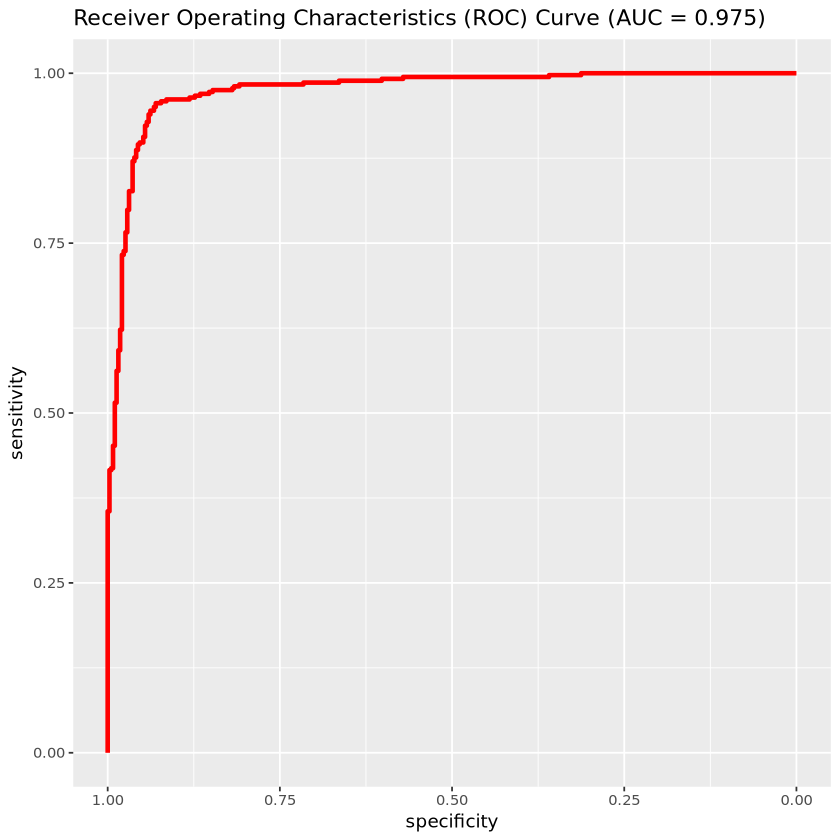

In [19]:
roc_churn <- roc(churn_predictions_ep$churn, churn_predictions_ep$predicted_churn)
auc_churn <- roc_churn$auc

# Creating ROC plot
ggroc(roc_churn, colour = 'red', size = 1.3) + ggtitle(paste0('Receiver Operating Characteristics (ROC) Curve ', '(AUC = ', round(auc_churn, digits = 3), ')'))

Delete the endpoint when done

In [20]:
model_endpoint$delete_endpoint(delete_endpoint_config=TRUE)